### import custom data

In [2]:
import copy
import pprint
pp = pprint.PrettyPrinter()
from functools import partial
from random import randint

# evaluate CRF model
!pip install sklearn-crfsuite
from sklearn_crfsuite import metrics
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

train_path = 'wnut17train.conll'
dev_path = 'emerging.dev.conll'
test_path = 'emerging.test.conll'


def file2data(path, test=False):
    with open(path, 'r') as file:
        sents = file.read()
        # split sents
        split_key = '\n\n' if test else '\n\t\n'
        sents = sents.split(split_key)
        sents = [s.split('\n') for s in sents]
        for i in range(len(sents)):
            sents[i] = [tuple(word.split('\t')) for word in sents[i]]
#             sents[i] = [tuple([pair[0], pair[1].split(',')[0]]) for pair in sents[i]]
        
        # last element is None
        sents.pop()
    return sents

train_data = file2data(train_path)
dev_data = file2data(dev_path, test=True)
test_data = file2data(test_path, test=True)
print(len(train_data))
print(len(dev_data))
print(len(test_data))
print(train_data[0])
print(test_data[0])
print()


# check labels
train_labels = set([word[1] for sent in train_data for word in sent])
dev_labels = set([word[1] for sent in dev_data for word in sent])
test_labels = set([word[1] for sent in test_data for word in sent])
print(train_labels)
print()
print(dev_labels)
print()
print(test_labels) # multi labels

     |████████████████████████████████| 747kB 8.5MB/s 
2394
1009
1287
[('@paulwalk', 'O'), ('It', 'O'), ("'s", 'O'), ('the', 'O'), ('view', 'O'), ('from', 'O'), ('where', 'O'), ('I', 'O'), ("'m", 'O'), ('living', 'O'), ('for', 'O'), ('two', 'O'), ('weeks', 'O'), ('.', 'O'), ('Empire', 'B-location'), ('State', 'I-location'), ('Building', 'I-location'), ('=', 'O'), ('ESB', 'B-location'), ('.', 'O'), ('Pretty', 'O'), ('bad', 'O'), ('storm', 'O'), ('here', 'O'), ('last', 'O'), ('evening', 'O'), ('.', 'O')]
[('&', 'O'), ('gt', 'O'), (';', 'O'), ('*', 'O'), ('The', 'O'), ('soldier', 'O'), ('was', 'O'), ('killed', 'O'), ('when', 'O'), ('another', 'O'), ('avalanche', 'O'), ('hit', 'O'), ('an', 'O'), ('army', 'O'), ('barracks', 'O'), ('in', 'O'), ('the', 'O'), ('northern', 'O'), ('area', 'O'), ('of', 'O'), ('Sonmarg', 'B-location'), (',', 'O'), ('said', 'O'), ('a', 'O'), ('military', 'O'), ('spokesman', 'O'), ('.', 'O')]

{'B-group', 'B-location', 'O', 'I-creative-work', 'B-product', 'I-product

### Data Preparation

In [3]:
# functions of sentence representations for sequence labelling
def sent2labels(sent):
    return [items[-1].split(',')[0] for items in sent]

def sent2tokens(sent):
    return [items[0] for items in sent]

# sentence representations for sequence labelling
def convert_labels_to_inds(sent_labels, label_2_id):
  return [label_2_id[label] for label in sent_labels]

def transform_tokens_labels(data):
    tokens = [sent2tokens(s) for s in data]
    labels = [sent2labels(s) for s in data]
    id_2_label = list(set([label for sent in labels for label in sent]))
    print("Number of unique labels in training data:", len(id_2_label))
    label_2_id = {label:i for i, label in enumerate(id_2_label)}
    label_inds = [convert_labels_to_inds(sent_labels, label_2_id) for sent_labels in labels]
    return tokens, label_inds, labels

train_sent_tokens, train_label_inds, train_labels = transform_tokens_labels(train_data)
train_id_2_label = list(set([label for sent in train_labels for label in sent]))

dev_sent_tokens, dev_label_inds, dev_labels = transform_tokens_labels(dev_data)
test_sent_tokens, test_label_inds, test_labels = transform_tokens_labels(train_data)

print(train_sent_tokens[0])
print(train_labels[0])
print(train_label_inds[0])

Number of unique labels in training data: 13
Number of unique labels in training data: 13
Number of unique labels in training data: 13
['@paulwalk', 'It', "'s", 'the', 'view', 'from', 'where', 'I', "'m", 'living', 'for', 'two', 'weeks', '.', 'Empire', 'State', 'Building', '=', 'ESB', '.', 'Pretty', 'bad', 'storm', 'here', 'last', 'evening', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-location', 'I-location', 'I-location', 'O', 'B-location', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 6, 6, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2]


In [4]:
window_size = 2

# converting tokenized sentence lists to vocabulary indices
id_2_word = list(set([token for sent in train_sent_tokens for token in sent])) + ["<pad>", "<unk>"]
word_2_id = {w:i for i,w in enumerate(id_2_word)}

def convert_tokens_to_inds(sentence, word_2_id):
    return [word_2_id.get(t, word_2_id["<unk>"]) for t in sentence]

# padding for windows
def pad_sentence_for_window(sentence, window_size=2, pad_token="<pad>"):
    return [pad_token]*window_size + sentence + [pad_token]*window_size 


In [5]:
# Batching sentences together with a DataLoader
torch.manual_seed(1)

def my_collate(data, window_size, word_2_id):
    """
    For some chunk of sentences and labels
        -add winow padding
        -pad for lengths using pad_sequence
        -convert our labels to one-hots
        -return padded inputs, one-hot labels, and lengths
    """
    
    x_s, y_s = zip(*data)

    # deal with input sentences as we've seen
    window_padded = [convert_tokens_to_inds(pad_sentence_for_window(sentence, window_size), word_2_id)
                                                                                  for sentence in x_s]
    # append zeros to each list of token ids in batch so that they are all the same length
    padded = nn.utils.rnn.pad_sequence([torch.LongTensor(t) for t in window_padded], batch_first=True)
    
    # convert labels to one-hots
    labels = []
    lengths = []
    for y in y_s:
        lengths.append(len(y))
        one_hot = torch.zeros(len(y), len(train_id_2_label))
        y = torch.tensor(y)
        y = y.unsqueeze(1)
        label = one_hot.scatter_(1, y, 1)
        labels.append(label)
    padded_labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    
    return padded.long(), padded_labels, torch.LongTensor(lengths)

In [6]:
class SoftmaxWordWindowClassifier(nn.Module):
    """
    A one-layer, binary word-window classifier.
    """
    def __init__(self, config, vocab_size, pad_idx=0):
        super(SoftmaxWordWindowClassifier, self).__init__()
        """
        Instance variables.
        """
        self.window_size = 2*config["half_window"]+1
        self.embed_dim = config["embed_dim"]
        self.hidden_dim = config["hidden_dim"]
        self.num_classes = config["num_classes"]
        self.freeze_embeddings = config["freeze_embeddings"]
        
        """
        Embedding layer
        -model holds an embedding for each layer in our vocab
        -sets aside a special index in the embedding matrix for padding vector (of zeros)
        -by default, embeddings are parameters (so gradients pass through them)
        """
        self.embed_layer = nn.Embedding(vocab_size, self.embed_dim, padding_idx=pad_idx)
        if self.freeze_embeddings:
            self.embed_layer.weight.requires_grad = False
        
        """
        Hidden layer
        -we want to map embedded word windows of dim (window_size+1)*self.embed_dim to a hidden layer.
        -nn.Sequential allows you to efficiently specify sequentially structured models
            -first the linear transformation is evoked on the embedded word windows
            -next the nonlinear transformation tanh is evoked.
        """
        self.hidden_layer = nn.Sequential(nn.Linear(self.window_size*self.embed_dim, 
                                                    self.hidden_dim), 
                                          nn.Tanh())
        
        """
        Output layer
        -we want to map elements of the output layer (of size self.hidden dim) to a number of classes.
        """
        self.output_layer = nn.Linear(self.hidden_dim, self.num_classes)
        
        """
        Softmax
        -The final step of the softmax classifier: mapping final hidden layer to class scores.
        -pytorch has both logsoftmax and softmax functions (and many others)
        -since our loss is the negative LOG likelihood, we use logsoftmax
        -technically you can take the softmax, and take the log but PyTorch's implementation
         is optimized to avoid numerical underflow issues.
        """
        self.log_softmax = nn.LogSoftmax(dim=2)
        
    def forward(self, inputs):
        """
        Let B:= batch_size
            L:= window-padded sentence length
            D:= self.embed_dim
            S:= self.window_size
            H:= self.hidden_dim
            
        inputs: a (B, L) tensor of token indices
        """
        B, L = inputs.size()
        
        """
        Reshaping.
        Takes in a (B, L) LongTensor
        Outputs a (B, L~, S) LongTensor
        """
        # Fist, get our word windows for each word in our input.
        token_windows = inputs.unfold(1, self.window_size, 1)
        _, adjusted_length, _ = token_windows.size()
        
        # Good idea to do internal tensor-size sanity checks, at the least in comments!
        assert token_windows.size() == (B, adjusted_length, self.window_size)
        
        """
        Embedding.
        Takes in a torch.LongTensor of size (B, L~, S) 
        Outputs a (B, L~, S, D) FloatTensor.
        """
        embedded_windows = self.embed_layer(token_windows)
        
        """
        Reshaping.
        Takes in a (B, L~, S, D) FloatTensor.
        Resizes it into a (B, L~, S*D) FloatTensor.
        -1 argument "infers" what the last dimension should be based on leftover axes.
        """
        embedded_windows = embedded_windows.view(B, adjusted_length, -1)
        
        """
        Layer 1.
        Takes in a (B, L~, S*D) FloatTensor.
        Resizes it into a (B, L~, H) FloatTensor
        """
        layer_1 = self.hidden_layer(embedded_windows)
        
        """
        Layer 2
        Takes in a (B, L~, H) FloatTensor.
        Resizes it into a (B, L~, 2) FloatTensor.
        """
        output = self.output_layer(layer_1)
        
        """
        Softmax.
        Takes in a (B, L~, 2) FloatTensor of unnormalized class scores.
        Outputs a (B, L~, 2) FloatTensor of (log-)normalized class scores.
        """
        output = self.log_softmax(output)
        
        return output

In [7]:
def loss_function(outputs, labels, lengths):
    """Computes negative LL loss on a batch of model predictions."""
    B, L, num_classes = outputs.size()
    num_elems = lengths.sum().float()
        
    # get only the values with non-zero labels
    loss = outputs*labels
    
    # rescale average
    return -loss.sum() / num_elems

def train_epoch(loss_function, optimizer, model, train_data):
    
    ## For each batch, we must reset the gradients
    ## stored by the model.    
    model.to(device)
    model.train()
    total_loss = 0
    for batch, labels, lengths in train_data:
        batch, labels, lengths = batch.to(device), labels.to(device), lengths.to(device)
        # clear gradients
        optimizer.zero_grad()
        # evoke model in training mode on batch
        outputs = model.forward(batch)
        # compute loss w.r.t batch
        loss = loss_function(outputs, labels, lengths)
        # pass gradients back, startiing on loss value
        loss.backward()
        # update parameters
        optimizer.step()
        total_loss += loss.item()

    # return the total to keep track of how you did this time around
    return total_loss

### Training

In [28]:
config = {"batch_size": 4,
          "half_window": 2,
          "embed_dim": 25,
          "hidden_dim": 25,
          "num_classes": 13, 
          "freeze_embeddings": False,
          'lr': 0.02,
          'epochs': 100,
         }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(model, config):
    learning_rate = config['lr'] # org: 0.0002
    num_epochs = config['epochs']

    # Shuffle True is good practice for train loaders.
    # Use functools.partial to construct a partially populated collate function
    train_loader = DataLoader(list(zip(train_sent_tokens, train_label_inds)), 
                                batch_size=config['batch_size'], shuffle=True, 
                                collate_fn=partial(my_collate, window_size=config['half_window'], word_2_id=word_2_id))    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5) # step=30, gamma=0.1 for epochs=100

    # TRAIN
    losses = []
    lr = []
    for epoch in range(num_epochs):    
        epoch_loss = train_epoch(loss_function, optimizer, model, train_loader)
        lr.append(scheduler.get_last_lr()[0])
        losses.append([epoch_loss])
        if epoch%20 == 0:
            print(epoch, epoch_loss)
        scheduler.step()

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].plot(range(num_epochs), lr)
    axes[0].set_title('learning rate')
    axes[1].plot(range(num_epochs), losses)
    axes[1].set_title('training loss')
    plt.show()

    return model

### Evaluation
There is much more O entities in data set, but we’re more interested in other entities. To account for this we’ll use averaged F1 score computed for all labels except for O. sklearn-crfsuite.metrics package provides some useful metrics for sequence classification task, including this one.

In [19]:
def eval(model, test_sent_tokens, test_label_inds, test_labels, config):    
    test_loader = DataLoader(list(zip(test_sent_tokens, test_label_inds)), 
                                batch_size=config['batch_size'], shuffle=False, 
                                collate_fn=partial(my_collate, window_size=config['half_window'], word_2_id=word_2_id))

    test_outputs = []
    for test_instance, labs, _ in test_loader:
        test_instance, labs = test_instance.to(device), labs.to(device)
        outputs_full = model.forward(test_instance)
        outputs = torch.argmax(outputs_full, dim=2)
        for i in range(outputs.size(0)):
            test_outputs.append(outputs[i].tolist())

    y_test = test_labels
    y_pred = []
    for test, pred in zip(test_labels, test_outputs):
        y_pred.append([train_id_2_label[id] for id in pred[:len(test)]])

    assert len(y_pred) == len(y_test), '{} vs. {}'.format(len(y_pred), len(y_test))
    for i, pred, test in zip(list(range(len(y_pred))), y_pred, y_test):
        assert len(pred) == len(test), '{}: {} vs. {}'.format(i, len(pred), len(test))

    f1 = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=train_id_2_label)
    print('check f1 score',f1)
    idx = randint(0, len(test_labels)-1)
    print('check random predictions')
    print('true labels: ', test_labels[idx])
    print('predicted labels: ',y_pred[idx])
    return f1, y_test, y_pred

### Inspect per-class results in more detail:

### Hyperparameter tuning

In [ ]:
# restart kernel so cleared outputs
params = {
'batch_size': 4,
 'embed_dim': [100, 200, 300],
 'freeze_embeddings': False,
 'half_window': [3, 4, 5],
 'hidden_dim': [50, 100],
 'num_classes': 13,
 'lr': [0.1],
}

params2tune = ['embed_dim', 'hidden_dim', 'lr', 'half_window']
for param in params2tune:
    temp = copy.copy(config)
    for val in params[param]:
        temp[param] = val
        print(param, val)
        model = SoftmaxWordWindowClassifier(config, len(word_2_id))
        model = train(model, temp)
        f1, _, _ = eval(model, dev_sent_tokens, dev_label_inds, dev_labels, temp)

### Train with optimal params

{'batch_size': 4, 'half_window': 2, 'embed_dim': 100, 'hidden_dim': 25, 'num_classes': 13, 'freeze_embeddings': False, 'lr': 0.02, 'epochs': 1000}
0 341.0711578093469
20 158.5276240594685
40 147.8348139990121
60 136.3057412393391
80 127.36744286306202
100 118.86299353837967
120 115.63777966424823
140 111.3352690115571
160 109.49670790042728
180 106.3065825952217
200 102.31963225826621
220 100.98802460543811
240 99.95833320869133
260 98.64964246377349
280 96.69916796218604
300 96.33948220126331
320 94.44644452538341
340 93.56727128662169
360 94.3340802770108
380 94.31676530558616
400 92.28549716062844
420 92.23177853925154
440 92.08689666353166
460 90.1944078207016
480 90.98448238102719
500 90.71044348413125
520 91.22237672284245
540 88.9292311258614
560 89.40400730445981
580 89.85433993628249
600 89.53317624609917
620 89.51861200574785
640 89.9917972208932
660 89.15616011852399
680 89.84686810523272
700 89.54060405213386
720 88.89983741892502
740 89.58677281020209
760 88.93170772492886

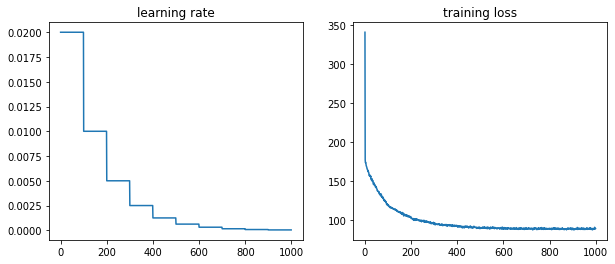

dev evaluation
check f1 score 0.8797339184825274
check random predictions
true labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
predicted labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
test evaluation
check f1 score 0.9510608524694358
check random predictions
true labels:  ['O', 'O', 'O', 'B-location', 'I-location', 'O', 'B-location']
predicted labels:  ['O', 'O', 'O', 'B-location', 'I-location', 'O', 'B-location']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

              O      0.968     0.999     0.983     44296
  B-corporation      0.744     0.362     0.487       177
  I-corporation      0.000     0.000     0.000        36
B-creative-work      0.458     0.103     0.168       107
I-creative-work      0.529     0.214     0.305       168
        B-group      0.692     0.061     0.112       148
        I-group      0.538     0.065     0.116       108
     B-location      0.731     0.437     0.547       391
     I-location      0.635     0.201     0.306       164
       B-person      0.512     0.184     0.270       468
       I-person      0.532     0.147     0.230       225
      B-product      0.600     0.030     0.057       100
      I-product      0.455     0.062     0.109        81

       accuracy                          0.962     46469
      macro avg      0.569     0.220     0.284     46469
   weighted avg      0.950     0.962     0.951     46469



In [35]:
sorted_labels = sorted(
    train_id_2_label,
    key=lambda name: (name[1:], name[0])
)

temp = copy.copy(config)
temp['embed_dim'] = 100
temp['epochs'] = 1000
temp['lr'] = 0.02
print(temp)
model = SoftmaxWordWindowClassifier(config, len(word_2_id))
model = train(model, temp)
print('dev evaluation')
f1, _, _ = eval(model, dev_sent_tokens, dev_label_inds, dev_labels, temp)
print('test evaluation')
f1, y_test, y_pred = eval(model, test_sent_tokens, test_label_inds, test_labels, temp)

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

In [33]:
torch.save(model.state_dict(), 'model_emb100_lr0.02_ep1000.pth')